**Shape from 3D objects (3D to 3D)**

Import standadrd Pytorch and Pytorch3D library

In [127]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [128]:
import os
import torch
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform,
    RasterizationSettings, BlendParams,
    MeshRenderer, MeshRasterizer, HardPhongShader
)
from pytorch3d.io import load_objs_as_meshes, load_obj, save_obj
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

Get cow and dolphin for testing and debug

In [129]:
#!wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
#!wget https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
#!wget https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
#!wget https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

Define Function

Create Mesh: Load in obj file and create Mesh Object

In [130]:
def create_mesh(filename):
  obj = os.path.join(filename)
  verts, faces, aux = load_obj(obj)

  faces_idx = faces.verts_idx.to(device)
  verts = verts.to(device)

  center = verts.mean(0)
  verts = verts - center
  scale = max(verts.abs().max(0)[0])
  verts = verts / scale

  return Meshes(verts=[verts], faces=[faces_idx])

Display Data

In [131]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
    
    fig = plt.figure(figsize=(5, 5))
   
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [132]:
def visualize_sil(silhouette_losses, edge_losses, normal_losses, laplacian_losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  ax.plot(silhouette_losses, label="silhouette loss")
  ax.plot(edge_losses, label="edge loss")
  ax.plot(normal_losses, label="normal loss")
  ax.plot(laplacian_losses, label="laplacian loss")
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");
  plt.show()

In [133]:
def visualize_quadric_loss(quadric_losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  ax.plot(quadric_losses, label="quadric loss")
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");
  plt.show()

In [134]:
def visualize_loss(chamfer_losses, edge_losses, normal_losses, laplacian_losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  ax.plot(chamfer_losses, label="chamfer loss")
  ax.plot(edge_losses, label="edge loss")
  ax.plot(normal_losses, label="normal loss")
  ax.plot(laplacian_losses, label="laplacian loss")
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");
  plt.show()

In [135]:
def display_mesh_3d(name_1, object_mesh_1, name_2, object_mesh_2):
  fig = plot_scene({
    name_1 : {
        "object_mesh_1": object_mesh_1,
    },
    name_2 : {
        "object_mesh_2": object_mesh_2
    }
  }, ncols = 2)
  fig.show()

In [136]:
def display_pointcloud_3d(name_1, object_mesh_1, name_2, object_mesh_2):
  point_cloud_obj_1 = Pointclouds(points=[sample_points_from_meshes(object_mesh_1, 5000)[0]])
  point_cloud_obj_2 = Pointclouds(points=[sample_points_from_meshes(object_mesh_2, 5000)[0]])

  fig = plot_scene({
    name_1 : {
        "object_pointcloud_1": point_cloud_obj_1
    },
    name_2 : {
        "object_pointcloud_2": point_cloud_obj_2
    }
  }, ncols = 2)
  fig.show()

In [137]:
def display_pointcloud_3d_single(name_1, object_mesh_1):
  point_cloud_obj_1 = Pointclouds(points=[sample_points_from_meshes(object_mesh_1, 5000)[0]])

  fig = plot_scene({
    name_1 + "_pointcloud" : {
        "object_pointcloud_1": point_cloud_obj_1,
    },
    name_1 + "_mesh" : {
        "object_mesh_1": object_mesh_1,
    },
  }, ncols = 2)
  fig.show()

Optimization / Molding Default

Default tuning values for learing rate, optimizer, and weights provided in Pytorch3D tutorial that proven to world very well with inputs such as dolphin.obj and cow.obj

In [138]:
def mesh_molding_default(object_mesh, sphere_mesh):
  deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
  optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

  # Number of optimization steps
  Niter = 2000
  # Weight for the chamfer loss
  w_chamfer = 1.0 
  # Weight for mesh edge loss
  w_edge = 1.0 
  # Weight for mesh normal consistency
  w_normal = 0.01 
  # Weight for mesh laplacian smoothing
  w_laplacian = 0.1
  # Plot period for the losses
  plot_period = 250
  loop = tqdm(range(Niter))

  check_point_meshes = []
  chamfer_losses = []
  laplacian_losses = []
  edge_losses = []
  normal_losses = []

  %matplotlib inline

  for i in loop:
      # Initialize optimizer
      optimizer.zero_grad()
      
      # Deform the mesh
      new_object_mesh = sphere_mesh.offset_verts(deform_verts)
      
      # We sample 5k points from the surface of each mesh 
      sample_trg = sample_points_from_meshes(object_mesh, 5000)
      sample_src = sample_points_from_meshes(new_object_mesh, 5000)
      
      # We compare the two sets of pointclouds by computing (a) the chamfer loss
      loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
      
      # and (b) the edge length of the predicted mesh
      loss_edge = mesh_edge_loss(new_object_mesh)
      
      # mesh normal consistency
      loss_normal = mesh_normal_consistency(new_object_mesh)
      
      # mesh laplacian smoothing
      loss_laplacian = mesh_laplacian_smoothing(new_object_mesh, method="uniform")
      
      # Weighted sum of the losses
      loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
      
      # Print the losses
      loop.set_description('total_loss = %.6f' % loss)
      
      # Save the losses for plotting
      chamfer_losses.append(float(loss_chamfer.detach().cpu()))
      edge_losses.append(float(loss_edge.detach().cpu()))
      normal_losses.append(float(loss_normal.detach().cpu()))
      laplacian_losses.append(float(loss_laplacian.detach().cpu()))
      
      # Plot mesh
      if i % plot_period == 0:
          check_point_meshes.append(new_object_mesh)
          #display_pointcloud_3d_single("iter: %d" % i, new_object_mesh)
          #plot_pointcloud(new_object_mesh, title="iter: %d" % i)
          
      # Optimization step
      loss.backward()
      optimizer.step()

  return new_object_mesh, chamfer_losses, edge_losses, normal_losses, laplacian_losses, check_point_meshes

Operation

Load Data

We use fox.obj as our ground truth 3D model as this example has lots of complexity such as curve as well as sharp edges.

In [139]:
filename = './obj_data/fox.obj'

#object_mesh = load_objs_as_meshes([filename], device=device)

object_mesh = create_mesh(filename)

Sphere Data Define For Molding

In [140]:
sphere_mesh = ico_sphere(4, device)

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



Display Meshes

In [141]:
display_mesh_3d("object_mesh", object_mesh, "sphere_mesh", sphere_mesh)

Molding Cube to Object Default

In [142]:
#new_object_mesh, chamfer_losses, edge_losses, normal_losses, laplacian_losses, check_point_meshes = mesh_molding_default(object_mesh, sphere_mesh)

Display progress

In [143]:
#for idx, val in enumerate(check_point_meshes):
#  display_pointcloud_3d_single("iter: %d" % (idx * 250), val)

Display Losses

In [144]:
#visualize_loss(chamfer_losses, edge_losses, normal_losses, laplacian_losses)

Display Result In 3D

In [145]:
#display_mesh_3d ("ground_truth_mesh", object_mesh, "mold_mesh", new_object_mesh)

Custom Molding Function

Experiment

Quadric Loss Implementation

All credits of quadric loss implementation goes to original implementation at https://github.com/nitinagarwal/QuadricLoss. Our contribution to this implementation is to examine file format as well as conversion between tensor and numpy to make it works with our pytorch3D pipeline. Our main goal with having quadric loss as part of our loss function is we would like to confirm our high level understanding of quadric loss in accordance with the paper: https://bmvc2019.org/wp-content/uploads/papers/0452-paper.pdf . We are curious to see if quadric loss in combination with chamfer, edge, normal, and laplacian improves our overall result.

In [146]:
def quadric_loss(Q, V, average=False):
    
    B = V.size()[0]
    N = V.size()[1]

    # V = BxNx4
    V = torch.cat((V, torch.ones(B, N, 1).cuda()), 2)

    # V = BxNx1x4
    V = torch.unsqueeze(V, 2)
    
    # V_trans = BxNx4x1
    V_trans = torch.transpose(V, 3, 2).contiguous()

    # BxNx4x4
    V_new = torch.matmul(V_trans, V)

    # BxNx16
    V_new = V_new.view(B, N, -1)

    Loss = (V_new*Q).sum(-1)
    if average:
        Loss = Loss.mean(-1)
    else:
        Loss = Loss.sum(-1)

    # computing the mean across batches
    return torch.mean(Loss)

def compute_Q_matrix(vertices, faces):

    num_pts = len(vertices)
    Q = np.zeros((num_pts, 4, 4), dtype=float)

    # computing Q for each vertex (v_q = Q1+Q2+Q3+....Q_n)
    for i in range(num_pts):
        idx = np.argwhere(faces == i)

        if(len(idx) > 0): 
            q = np.zeros((4,4), dtype=float)

            length = len(idx)
            for j in range(length):
                f = faces[idx[j,0]]
                [v1, v2, v3] = vertices[f[0],:], vertices[f[1],:], vertices[f[2],:]
                v1 = v1.astype(float)
                v2 = v2.astype(float)
                v3 = v3.astype(float)
                q = q + get_plane(v1, v2, v3)
            Q[i,:,:] = q

    return Q


def get_plane(v1, v2, v3):

    normal =  np.cross(v1 - v2, v1 - v3)
    mag = np.sqrt(np.dot(normal, normal))

    #avoid divide by zero
    if mag != 0:
        normal = normal / mag

    d =  - np.dot(normal, v1)

    equ = np.array([normal[0], normal[1], normal[2], d])
    Q = np.outer(equ,equ)
    
    return Q

def load_obj_data(filename):
    ver = []
    fac = []

    with open(filename) as f:
        for line in f:
            if line.strip():
                inp = line.split()
                if(inp[0]=='v'):
                    ver.append([float(inp[1]), float(inp[2]), float(inp[3])])
                elif(inp[0]=='f'):
                    v1 = inp[1].split("/")[0]
                    v2 = inp[2].split("/")[0]
                    v3 = inp[3].split("/")[0]
                    fac.append([int(v1)-1, int(v2)-1, int(v3)-1])

    V = np.array(ver)
    F = np.array(fac)
    
    return V, F

Compute Q Matrix For Quadric Loss

Q matrix takes the ground truth object into consideration to generate plane values therefore in later stage it will be unfit to work with images as ground truth

In [147]:
vertices, faces = load_obj_data(filename)
vert_len = len(vertices)

Q_matrix = torch.from_numpy(compute_Q_matrix(vertices, faces).astype(np.float32))
Q_matrix = Q_matrix.view(vertices.shape[0], -1)
Q_matrix = Q_matrix.to(device)
print(Q_matrix)

tensor([[ 3.7098e+00,  1.9835e+00, -2.5341e-01,  ..., -1.4494e+02,
          1.9902e+01,  9.7094e+03],
        [ 5.0223e+00, -7.8725e-01,  2.1326e-01,  ..., -1.3073e+01,
          2.2594e+01,  1.3340e+03],
        [ 7.7888e+00,  1.7408e-01,  1.1515e-01,  ..., -9.1255e+00,
          1.5138e+00,  1.5931e+03],
        ...,
        [ 1.6957e+00,  1.4022e+00, -1.0812e+00,  ..., -2.4679e+01,
          1.8394e+01,  3.7912e+02],
        [ 4.8561e+00, -1.2507e+00,  1.2035e+00,  ...,  1.9153e+00,
         -2.1195e+00,  2.4796e+02],
        [ 3.5502e+00,  1.7223e+00, -1.3493e+00,  ..., -2.9088e+00,
          1.4032e+00,  4.3670e+01]], device='cuda:0')


Define custom optimization function.

In [148]:
def mesh_molding_custom(object_mesh, sphere_mesh, iteration, learning_rate, momentum_in, chamfer_weight, edge_weight, normal_weight, laplacian_weight, quadric_weight, sampling_points, allow_draw_checkpoint, allow_quadric_loss):
  
  deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
  #optimizer = torch.optim.SGD([deform_verts], lr=learning_rate, momentum=momentum_in)
  optimizer = torch.optim.Adam([deform_verts], lr=learning_rate)        
  Niter = iteration
  # Weight for the chamfer loss
  w_chamfer = chamfer_weight
  # Weight for mesh edge loss
  w_edge = edge_weight
  # Weight for mesh normal consistency
  w_normal = normal_weight
  # Weight for mesh laplacian smoothing
  w_laplacian = laplacian_weight
  # Plot period for the losses
  plot_period = 250
  loop = tqdm(range(Niter))

  check_point_meshes = []
  chamfer_losses = []
  laplacian_losses = []
  edge_losses = []
  normal_losses = []
  quadric_losses = []

  %matplotlib inline

  for i in loop:
      # Initialize optimizer
      optimizer.zero_grad()
      
      # Deform the mesh
      new_object_mesh = sphere_mesh.offset_verts(deform_verts)
      
      # We sample 5k points from the surface of each mesh 
      sample_trg = sample_points_from_meshes(object_mesh, sampling_points)
      sample_src = sample_points_from_meshes(new_object_mesh, sampling_points)
      
      # We compare the two sets of pointclouds by computing (a) the chamfer loss
      loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
      
      # and (b) the edge length of the predicted mesh
      loss_edge = mesh_edge_loss(new_object_mesh)
      
      # mesh normal consistency
      loss_normal = mesh_normal_consistency(new_object_mesh)
      
      # mesh laplacian smoothing
      loss_laplacian = mesh_laplacian_smoothing(new_object_mesh, method="uniform")

      # quadric loss
      loss_quadric = quadric_loss(Q_matrix, sample_points_from_meshes(new_object_mesh, vert_len))
      
      # Weighted sum of the losses

      if allow_quadric_loss:
        loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian + quadric_weight * loss_quadric
      else:
        loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
      
      # Print the losses
      loop.set_description('total_loss = %.6f' % loss)
      
      # Save the losses for plotting
      chamfer_losses.append(float(loss_chamfer.detach().cpu()))
      edge_losses.append(float(loss_edge.detach().cpu()))
      normal_losses.append(float(loss_normal.detach().cpu()))
      laplacian_losses.append(float(loss_laplacian.detach().cpu()))
      quadric_losses.append(float(loss_quadric.detach().cpu()))
      
      # Plot mesh
      if i % plot_period == 0:
          check_point_meshes.append(new_object_mesh)
          if allow_draw_checkpoint:
            plot_pointcloud(new_object_mesh, title="iter: %d" % i)
          
      # Optimization step
      loss.backward()
      optimizer.step()

  return new_object_mesh, chamfer_losses, edge_losses, normal_losses, laplacian_losses, quadric_losses, check_point_meshes

Weight Tunning Quadric

In [149]:
# iteration = 2000
# learning_rate = 0.001
# momentum_in = 1.0
# chamfer_weight = 1.0
# edge_weight = 1.0
# normal_weight = 0.01
# laplacian_weight = 0.1
# sampling_points = 5000

iteration = 2000
learning_rate = 0.001
momentum_in = 1.0
chamfer_weight = 1.0
edge_weight = 1.0
normal_weight = 0.05
laplacian_weight = 0.1
quadric_weight = 0.0000095 
sampling_points = 5000
allow_draw_checkpoint = True
allow_quadric_loss = True

Molding With Quadric

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



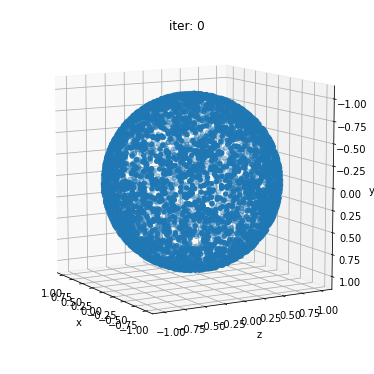

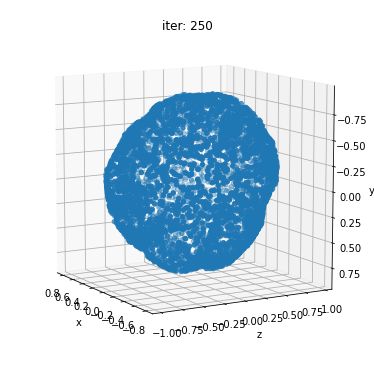

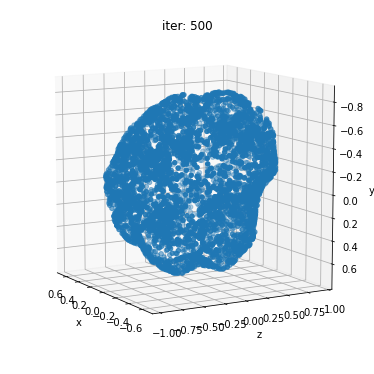

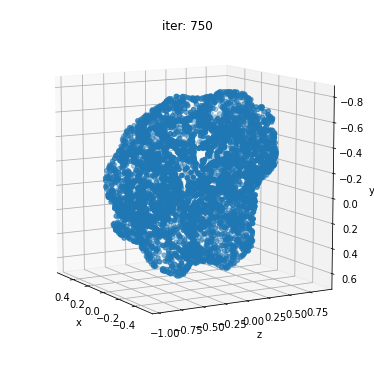

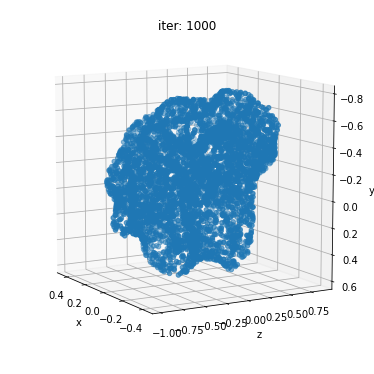

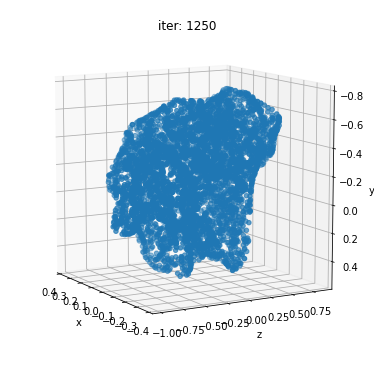

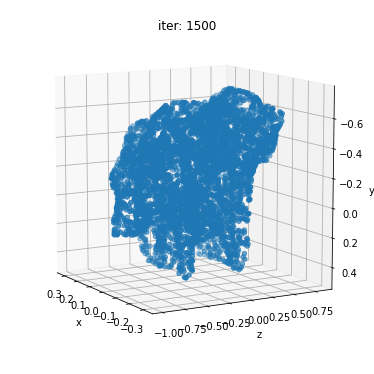

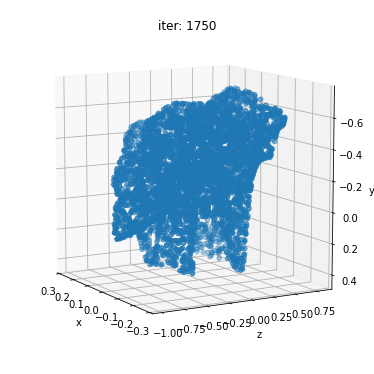

In [150]:
new_object_mesh, chamfer_losses, edge_losses, normal_losses, laplacian_losses, quadric_losses, check_point_meshes = mesh_molding_custom(object_mesh, sphere_mesh, iteration, learning_rate, momentum_in, chamfer_weight, edge_weight, normal_weight, laplacian_weight, quadric_weight, sampling_points, allow_draw_checkpoint, allow_quadric_loss)

Visualize Quadric Loss

We observe that while quadric loss goes down at each iteration, it is very noisy and start it very high value. Therefore, we have to multiply it with a very small weight to balance with other loss functions.

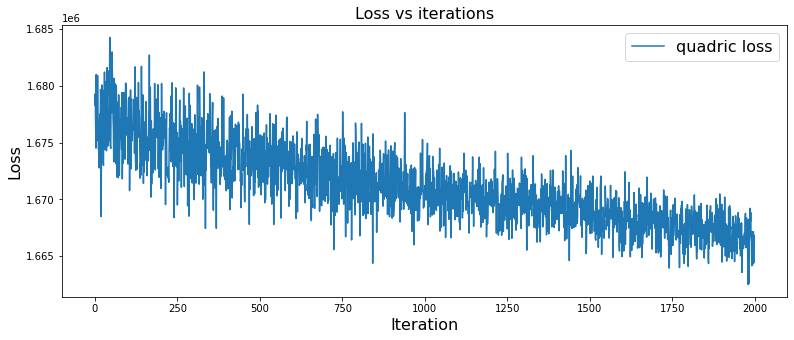

In [151]:
visualize_quadric_loss( quadric_losses)

Visualize Other Losses

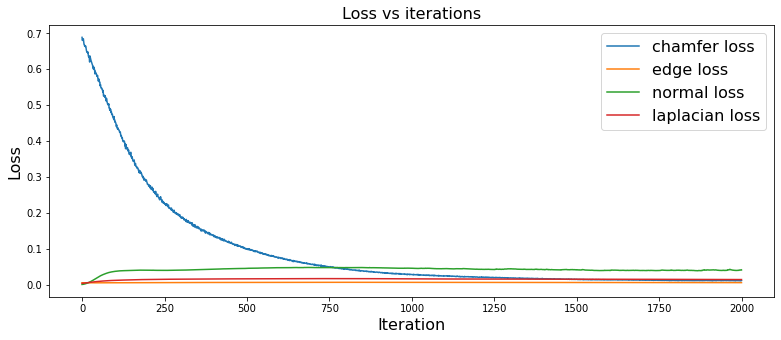

In [152]:
visualize_loss(chamfer_losses, edge_losses, normal_losses, laplacian_losses)

Final Result With Quadric Loss

Surprisingly quadric loss is greatly improve our overall result and we can see the fox leg has a small curve shape and closer to grouth truth model. This is expected as quadric loss helps improve molding in sharp edges. Here in this case is the area between the legs of the fox 

In [153]:
display_pointcloud_3d_single("iter: %d" % (len(check_point_meshes) * 250), check_point_meshes[len(check_point_meshes)-1])

Molding Without Quadric Loss

In [154]:
allow_draw_checkpoint = False
allow_quadric_loss = False
new_object_mesh, chamfer_losses, edge_losses, normal_losses, laplacian_losses, quadric_losses, check_point_meshes = mesh_molding_custom(object_mesh, sphere_mesh, iteration, learning_rate, momentum_in, chamfer_weight, edge_weight, normal_weight, laplacian_weight, quadric_weight, sampling_points, allow_draw_checkpoint, allow_quadric_loss)

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



In [155]:
display_pointcloud_3d_single("iter: %d" % (len(check_point_meshes) * 250), check_point_meshes[len(check_point_meshes)-1])

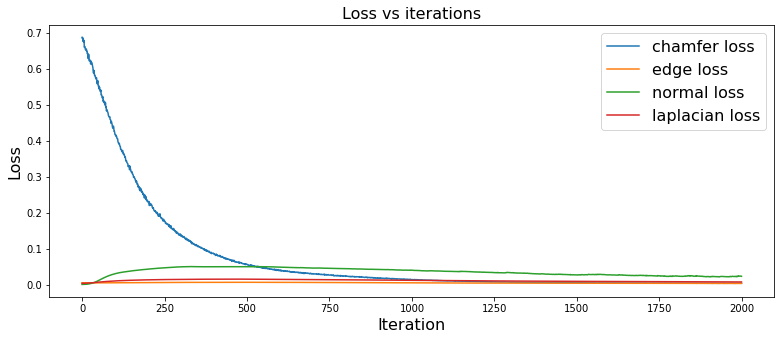

In [156]:
visualize_loss(chamfer_losses, edge_losses, normal_losses, laplacian_losses)

**Shape from Images (2D s to 3D)**

In [157]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex,
    SoftSilhouetteShader,
    OpenGLPerspectiveCameras
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2021-12-21 19:38:44--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1606 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.2’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-12-21 19:38:44 (24.8 MB/s) - ‘plot_image_grid.py.2’ saved [1606/1606]



Load Object

In [158]:
# Load objs as meshes also load in texture
mesh = load_objs_as_meshes([filename], device=device)

# Our fox model is very big. Therefore we have to scale it down
mesh = mesh.scale_verts_(0.015)

# Create 20 different angle views
batch_size = 20

Declare camera settings and try to render some images

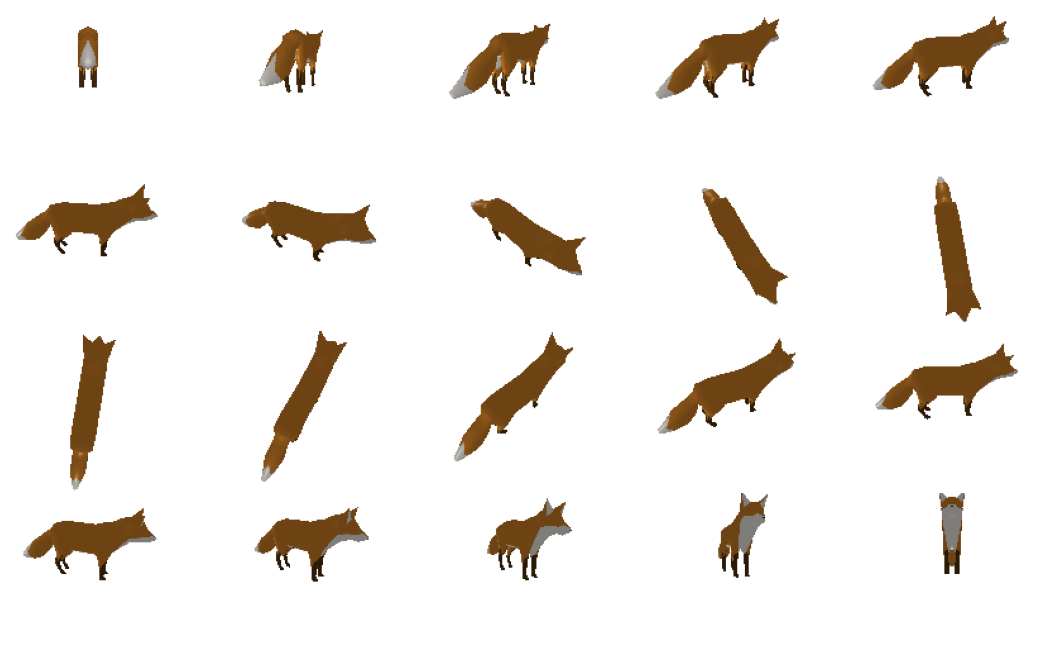

In [159]:
# Generate array of meshes
meshes = mesh.extend(batch_size)

# Elevation moving up and down (from 0 to 180 degree)
# Azim moving left and right (from -180 to 180 degree left to right)
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# Create camera
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...]) 

# Create light object
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Raster settings
raster_settings = RasterizationSettings(
    image_size=128, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)

# Try out for camera to capture images with lights on mesh object
images = renderer(meshes, cameras=cameras, lights=lights)

# Display images
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

Declare Sillouette Camera Settings And Try To Render Sillouette

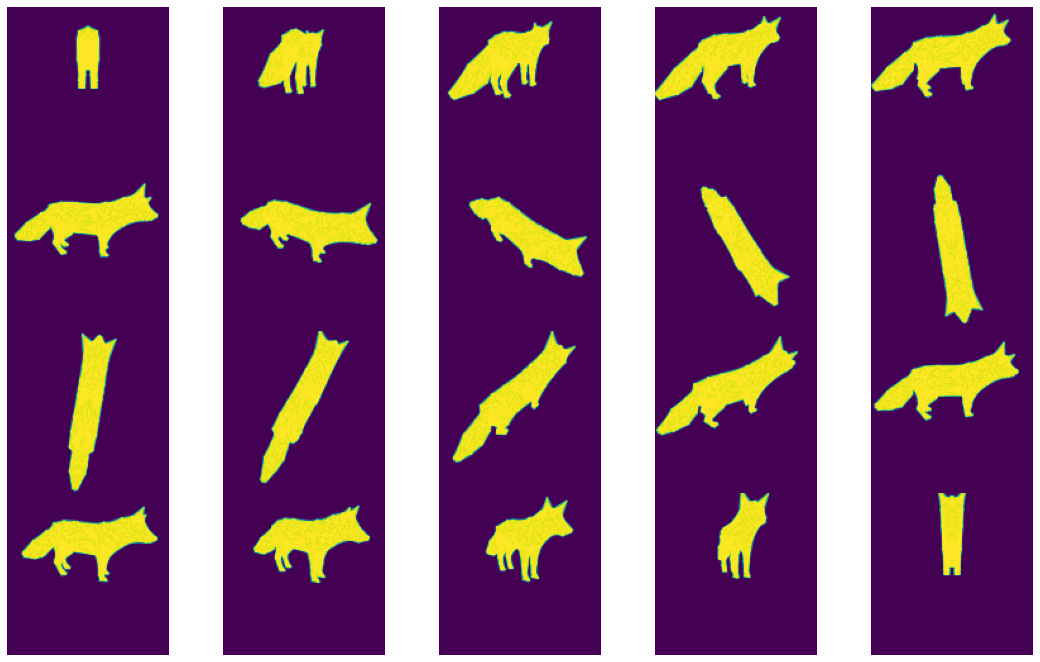

In [160]:
# Generate array of meshes
meshes = mesh.extend(batch_size)

# Elevation moving up and down (from 0 to 180 degree)
# Azim moving left and right (from -180 to 180 degree left to right)
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# Create camera
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...]) 

# Create light
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Settings for rasterize
raster_settings_silhouette = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*1e-4, 
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Try to render sillouette
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(batch_size)]

# Display sillouette
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)

Molding function for images

In [161]:
def mesh_molding_for_images(images, sphere_mesh, iteration, learning_rate, momentum_in, chamfer_weight, edge_weight, normal_weight, laplacian_weight, quadric_weight, sampling_points, allow_draw_checkpoint, allow_quadric_loss, allow_adam):
  
  view_iter = 2

  # Define target cameras to iterate and cross check molding progess
  target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], T=T[None, i, ...]) for i in range(batch_size)]

  deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
  optimizer = torch.optim.SGD([deform_verts], lr=learning_rate, momentum=momentum_in)
  
  if allow_adam:
    optimizer = torch.optim.Adam([deform_verts], lr=learning_rate)        
  
  Niter = iteration
  # Weight for the chamfer loss
  w_chamfer = chamfer_weight
  # Weight for mesh edge loss
  w_edge = edge_weight
  # Weight for mesh normal consistency
  w_normal = normal_weight
  # Weight for mesh laplacian smoothing
  w_laplacian = laplacian_weight
  # Plot period for the losses
  plot_period = 250
  loop = tqdm(range(Niter))

  check_point_meshes = []
  chamfer_losses = []
  laplacian_losses = []
  edge_losses = []
  normal_losses = []
  quadric_losses = []
  silhouette_losses = []

  %matplotlib inline

  for i in loop:
      loss_silhouette_for_batch = 0
      # Initialize optimizer
      optimizer.zero_grad()
      
      # Deform the mesh
      new_object_mesh = sphere_mesh.offset_verts(deform_verts)
      
      # Sample 5000 points
      #sample_trg = sample_points_from_meshes(object_mesh, sampling_points)

      sample_src = sample_points_from_meshes(new_object_mesh, sampling_points)
      
      # Does not consider chamger loss as quadric requires a sample the grouth truth 3D model

      # We compare the two sets of pointclouds by computing (a) the chamfer loss
      #loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
      
      # edge length
      loss_edge = mesh_edge_loss(new_object_mesh)
      
      # mesh normal consistency
      loss_normal = mesh_normal_consistency(new_object_mesh)
      
      # mesh laplacian smoothing
      loss_laplacian = mesh_laplacian_smoothing(new_object_mesh, method="uniform")

      # quadric loss
      # loss_quadric = quadric_loss(Q_matrix, sample_points_from_meshes(new_object_mesh, vert_len))

      # By taking the predicted sillouette render from our camera compare with the grouth truth sillouette
      # We are able to compute the loss function by using l2 norm

      for j in np.random.permutation(batch_size).tolist()[:view_iter]:
        images_predicted = renderer_silhouette(new_object_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss_silhouette_for_batch += loss_silhouette / view_iter
      
      # Does not consider quadric loss as quadric requires a sample the grouth truth 3D model
      # if allow_quadric_loss:
      #   loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian + quadric_weight * loss_quadric
      # else:
      #   loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian + ls

      loss = torch.tensor(0.0, device=device)
      loss = loss_edge * edge_weight + loss_normal * normal_weight + loss_laplacian * laplacian_weight + loss_silhouette_for_batch * 1.0
      
      # Print the losses
      loop.set_description('total_loss = %.6f' % loss)
      
      # Save the losses for plotting
      #chamfer_losses.append(float(loss_chamfer.detach().cpu()))
      edge_losses.append(float(loss_edge.detach().cpu()))
      normal_losses.append(float(loss_normal.detach().cpu()))
      laplacian_losses.append(float(loss_laplacian.detach().cpu()))
      silhouette_losses.append(float(loss_silhouette_for_batch.detach().cpu()))
      #quadric_losses.append(float(loss_quadric.detach().cpu()))
      
      # Plot mesh
      if i % plot_period == 0:
          check_point_meshes.append(new_object_mesh)
          if allow_draw_checkpoint:
            plot_pointcloud(new_object_mesh, title="iter: %d" % i)
          
      # Optimization step
      loss.backward()
      optimizer.step()

  return new_object_mesh, chamfer_losses, edge_losses, normal_losses, laplacian_losses, quadric_losses, silhouette_losses, check_point_meshes

With SGD

In [162]:
iteration = 2000
learning_rate = 1.0
momentum_in = 0.9
# learning_rate = 0.001
# momentum_in = 1.0
chamfer_weight = 0.0
edge_weight = 1.0
normal_weight = 0.01
laplacian_weight = 1.0
quadric_weight = 0.0
sampling_points = 5000
allow_draw_checkpoint = True
allow_quadric_loss = False
allow_adam = False

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



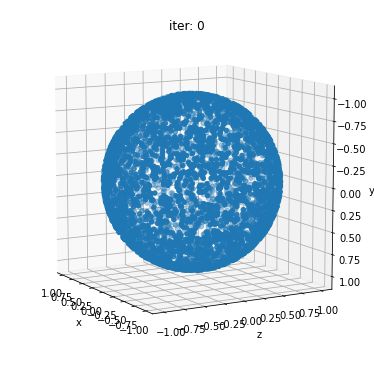

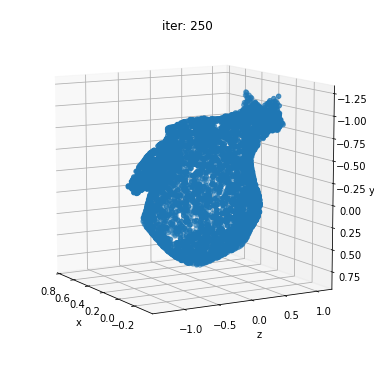

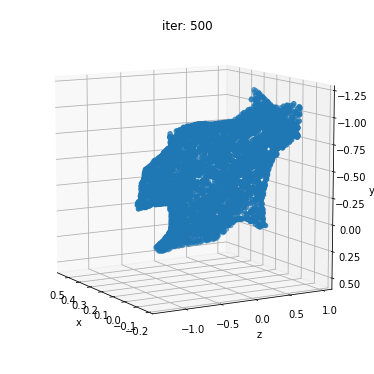

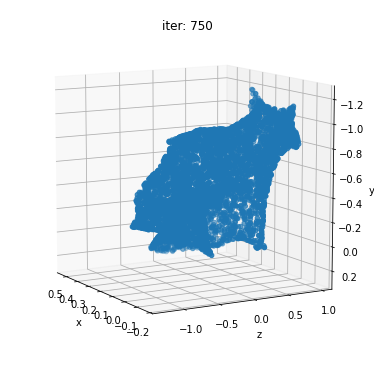

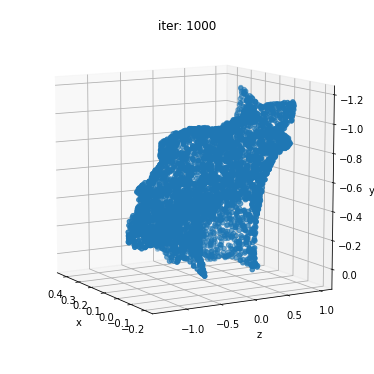

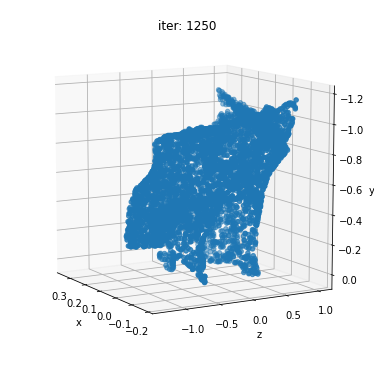

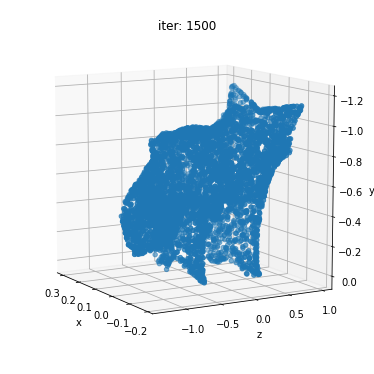

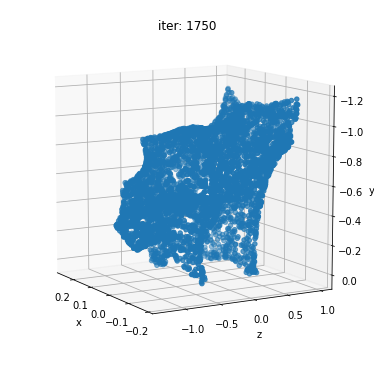

In [163]:
new_object_mesh, chamfer_losses, edge_losses, normal_losses, laplacian_losses, quadric_losses, silhouette_losses, check_point_meshes = mesh_molding_for_images(object_mesh, sphere_mesh, iteration, learning_rate, momentum_in, chamfer_weight, edge_weight, normal_weight, laplacian_weight, quadric_weight, sampling_points, allow_draw_checkpoint, allow_quadric_loss, allow_adam)

In [164]:
display_pointcloud_3d_single("iter: %d" % (len(check_point_meshes) * 250), check_point_meshes[len(check_point_meshes)-1])

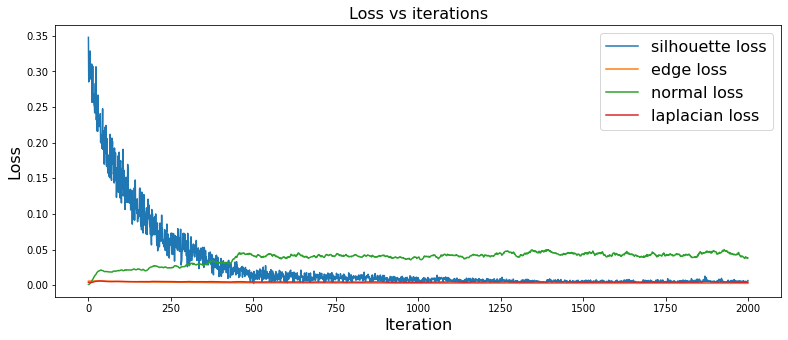

In [165]:
visualize_sil(silhouette_losses, edge_losses, normal_losses, laplacian_losses)

With Adam

In [166]:
iteration = 2000
#learning_rate = 1.0
momentum_in = 0.9
learning_rate = 0.001
# momentum_in = 1.0
chamfer_weight = 0.0
edge_weight = 1.0
normal_weight = 0.01
laplacian_weight = 1.0
quadric_weight = 0.0
sampling_points = 5000
allow_draw_checkpoint = False
allow_quadric_loss = False
allow_adam = True

In [167]:
new_object_mesh, chamfer_losses, edge_losses, normal_losses, laplacian_losses, quadric_losses, silhouette_losses, check_point_meshes = mesh_molding_for_images(object_mesh, sphere_mesh, iteration, learning_rate, momentum_in, chamfer_weight, edge_weight, normal_weight, laplacian_weight, quadric_weight, sampling_points, allow_draw_checkpoint, allow_quadric_loss, allow_adam)

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



In [168]:
display_pointcloud_3d_single("iter: %d" % (len(check_point_meshes) * 250), new_object_mesh)

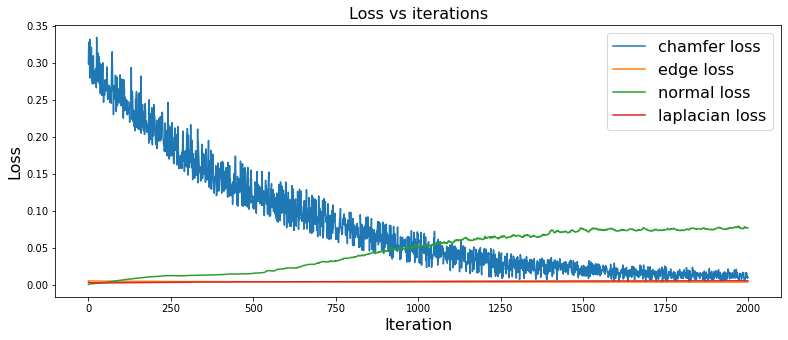

In [169]:
visualize_loss(silhouette_losses, edge_losses, normal_losses, laplacian_losses)

**Shape From Synthetic GAN Image (2D to 3D)**

We use a synthethic pretrain resnet specialize in object segmentation to seperate our object from the background.

In [170]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [171]:
from PIL import Image
from torchvision import transforms

def create_image_sillouette(filename):
  
  input_image = Image.open(filename)
  input_image = input_image.convert("RGB")
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  return output_predictions

Load and segment synthetic images

In [172]:
images_grouth_truth = []

images_grouth_truth.append(create_image_sillouette("./obj_data/seed6918.png"))
images_grouth_truth.append(create_image_sillouette("./obj_data/seed6919.png"))
images_grouth_truth.append(create_image_sillouette("./obj_data/seed6920.png"))
images_grouth_truth.append(create_image_sillouette("./obj_data/seed6921.png"))
images_grouth_truth.append(create_image_sillouette("./obj_data/seed6922.png"))
images_grouth_truth.append(create_image_sillouette("./obj_data/seed6923.png"))

target_silhouette = images_grouth_truth

Sample Original Display

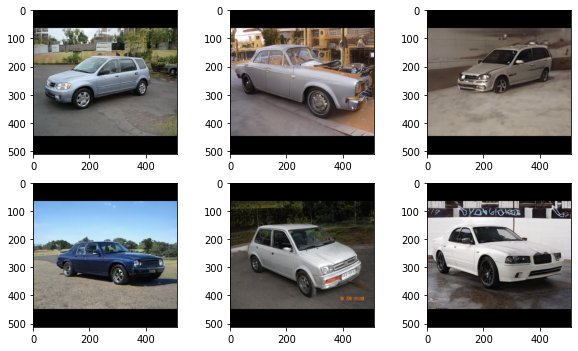

In [173]:
files = ["./obj_data/seed6918.png", "./obj_data/seed6919.png", "./obj_data/seed6920.png", "./obj_data/seed6921.png", "./obj_data/seed6922.png", "./obj_data/seed6923.png"]
fig = plt.figure(figsize=(10, 9))
count = 1
for i in files:
  Image.open(i)
  ax1 = fig.add_subplot(3,3,count)
  ax1.imshow(Image.open(i))
  count += 1

Sample Silhouette Display

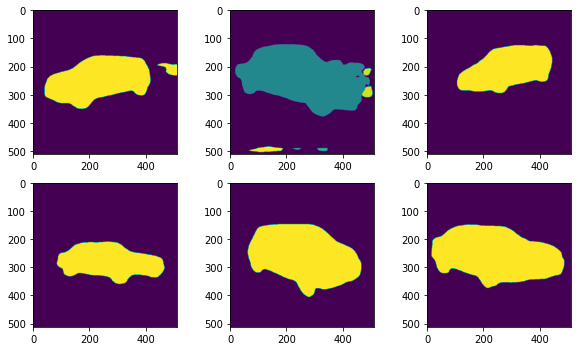

In [174]:
fig = plt.figure(figsize=(10, 9))
count = 1
for i in images_grouth_truth:
  ax1 = fig.add_subplot(3,3,count)
  ax1.imshow(Image.fromarray(i.byte().cpu().numpy()))
  count += 1

In [175]:

batch_size = 5
# Elevation moving up and down (from 0 to 180 degree)
# Azim moving left and right (from -180 to 180 degree left to right)
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# Create camera
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...]) 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
# Settings for rasterize
raster_settings_silhouette = RasterizationSettings(
    image_size=512, 
    blur_radius=np.log(1. / 1e-4 - 1.)*1e-4, 
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

In [176]:
def mesh_molding_for_images(images, sphere_mesh, iteration, learning_rate, momentum_in, chamfer_weight, edge_weight, normal_weight, laplacian_weight, quadric_weight, sampling_points, allow_draw_checkpoint, allow_quadric_loss):
  
  view_iter = 2

  # Define target cameras to iterate and cross check molding progess
  target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], T=T[None, i, ...]) for i in range(batch_size)]

  deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
  optimizer = torch.optim.SGD([deform_verts], lr=learning_rate, momentum=momentum_in)
  #optimizer = torch.optim.Adam([deform_verts], lr=learning_rate)        
  Niter = iteration
  # Weight for the chamfer loss
  w_chamfer = chamfer_weight
  # Weight for mesh edge loss
  w_edge = edge_weight
  # Weight for mesh normal consistency
  w_normal = normal_weight
  # Weight for mesh laplacian smoothing
  w_laplacian = laplacian_weight
  # Plot period for the losses
  plot_period = 250
  loop = tqdm(range(Niter))

  check_point_meshes = []
  chamfer_losses = []
  laplacian_losses = []
  edge_losses = []
  normal_losses = []
  quadric_losses = []
  silhouette_losses = []
  

  %matplotlib inline

  for i in loop:
      loss_silhouette_for_batch = 0
      # Initialize optimizer
      optimizer.zero_grad()
      
      # Deform the mesh
      new_object_mesh = sphere_mesh.offset_verts(deform_verts)
      
      # Sample 5000 points
      #sample_trg = sample_points_from_meshes(object_mesh, sampling_points)

      sample_src = sample_points_from_meshes(new_object_mesh, sampling_points)
      
      # Does not consider chamger loss as quadric requires a sample the grouth truth 3D model

      # We compare the two sets of pointclouds by computing (a) the chamfer loss
      #loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
      
      # edge length
      loss_edge = mesh_edge_loss(new_object_mesh)
      
      # mesh normal consistency
      loss_normal = mesh_normal_consistency(new_object_mesh)
      
      # mesh laplacian smoothing
      loss_laplacian = mesh_laplacian_smoothing(new_object_mesh, method="uniform")

      # quadric loss
      # loss_quadric = quadric_loss(Q_matrix, sample_points_from_meshes(new_object_mesh, vert_len))

      # By taking the predicted sillouette render from our camera compare with the grouth truth sillouette
      # We are able to compute the loss function by using l2 norm

      for j in np.random.permutation(batch_size).tolist()[:view_iter]:
        images_predicted = renderer_silhouette(new_object_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss_silhouette_for_batch += loss_silhouette / view_iter
      
      # Does not consider quadric loss as quadric requires a sample the grouth truth 3D model
      # if allow_quadric_loss:
      #   loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian + quadric_weight * loss_quadric
      # else:
      #   loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian + ls

      loss = torch.tensor(0.0, device=device)
      loss = loss_edge * edge_weight + loss_normal * normal_weight + loss_laplacian * laplacian_weight + loss_silhouette_for_batch * 1.0
      
      # Print the losses
      loop.set_description('total_loss = %.6f' % loss)
      
      # Save the losses for plotting
      #chamfer_losses.append(float(loss_chamfer.detach().cpu()))
      edge_losses.append(float(loss_edge.detach().cpu()))
      normal_losses.append(float(loss_normal.detach().cpu()))
      laplacian_losses.append(float(loss_laplacian.detach().cpu()))
      silhouette_losses.append(float(loss_silhouette_for_batch.detach().cpu()))
      #quadric_losses.append(float(loss_quadric.detach().cpu()))
      
      # Plot mesh
      if i % plot_period == 0 and allow_draw_checkpoint:
          check_point_meshes.append(new_object_mesh)
          plot_pointcloud(new_object_mesh, title="iter: %d" % i)
          
      # Optimization step
      loss.backward()
      optimizer.step()

  return new_object_mesh, chamfer_losses, edge_losses, normal_losses, laplacian_losses, quadric_losses, silhouette_losses, check_point_meshes

In [177]:
iteration = 2000
learning_rate = 1.0
momentum_in = 0.9
# learning_rate = 0.001
# momentum_in = 1.0
chamfer_weight = 0.0
edge_weight = 1.0
normal_weight = 0.01
laplacian_weight = 1.0
quadric_weight = 0.0
sampling_points = 5000
allow_draw_checkpoint = True
allow_quadric_loss = False

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch3d/structures/meshes.py:1108: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').



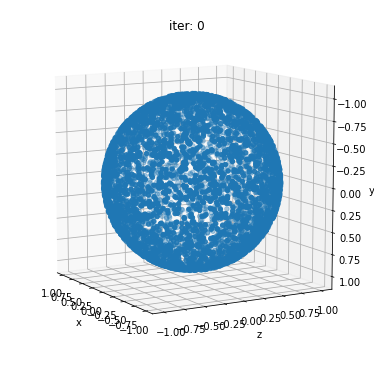

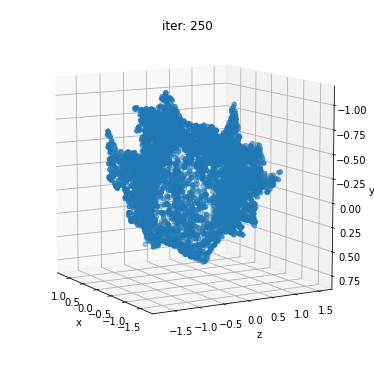

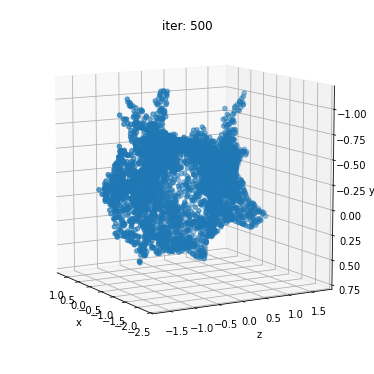

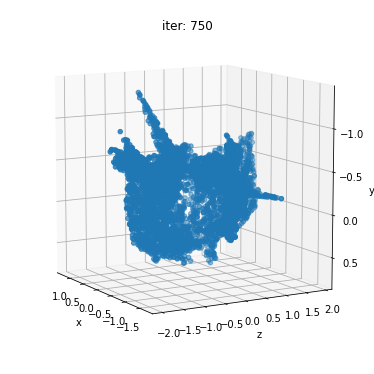

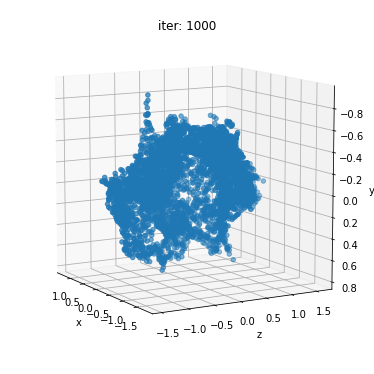

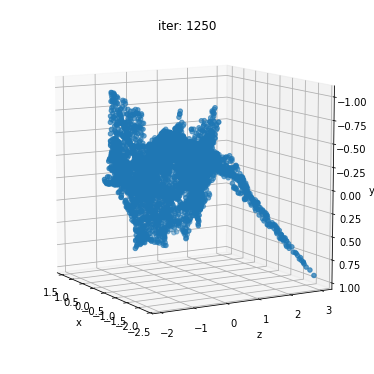

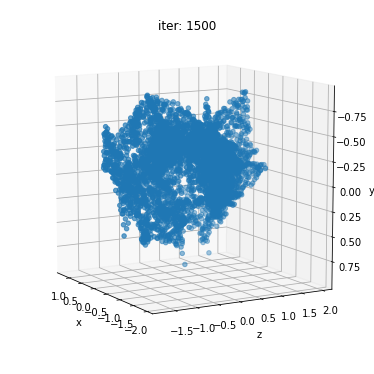

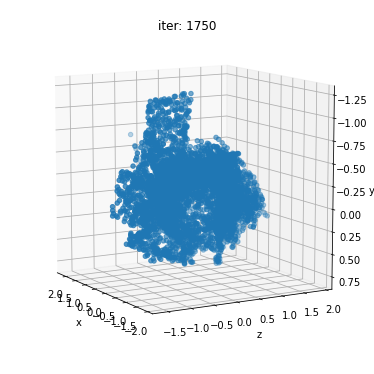

In [178]:
new_object_mesh, chamfer_losses, edge_losses, normal_losses, laplacian_losses, quadric_losses, silhouette_losses, check_point_meshes = mesh_molding_for_images(sphere_mesh, sphere_mesh, iteration, learning_rate, momentum_in, chamfer_weight, edge_weight, normal_weight, laplacian_weight, quadric_weight, sampling_points, allow_draw_checkpoint, allow_quadric_loss)

In [179]:
display_pointcloud_3d_single("iter: %d" % (len(check_point_meshes) * 250), check_point_meshes[len(check_point_meshes)-1])

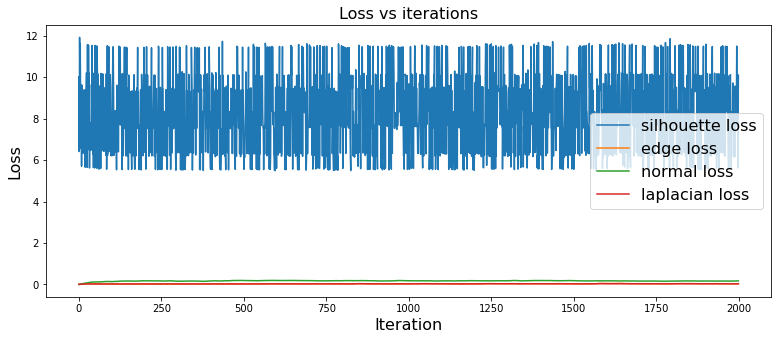

In [181]:
visualize_sil(silhouette_losses, edge_losses, normal_losses, laplacian_losses)